In [1]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


## Text Classification

In this notebook we'll demonstrate and compare two approaches for text classification.  As an example we'll classify technical support help requests into categories using a dataset downloaded from Kaggle.

In the first approach we'll use analyze the frequency of words within and between documents to convert each document into a vector.  The vectors from this classical approach are 

### Imports and Configuration

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
import torch
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

from introdl.utils import config_paths_keys

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys(env_path='../Course_Tools/mac.env')
#paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

# for just this lesson
LESSON_DATA_PATH = Path('./data').resolve()
data_path = LESSON_DATA_PATH / 'IT_tickets_classify.csv'

MODELS_PATH=/Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Python_Projects/DS776_Develop_Project/models
DATA_PATH=/Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Python_Projects/DS776_Develop_Project/data
TORCH_HOME=/Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Python_Projects/DS776_Develop_Project/downloads
HF_HOME=/Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Python_Projects/DS776_Develop_Project/downloads


### Load and Visualize Data

In [2]:
data_path = Path('./data/IT_tickets_classify.csv').resolve() 
df = pd.read_csv(data_path)

print(f'This dataset has {df.shape[0]} IT tickets')

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

This dataset has 47837 IT tickets


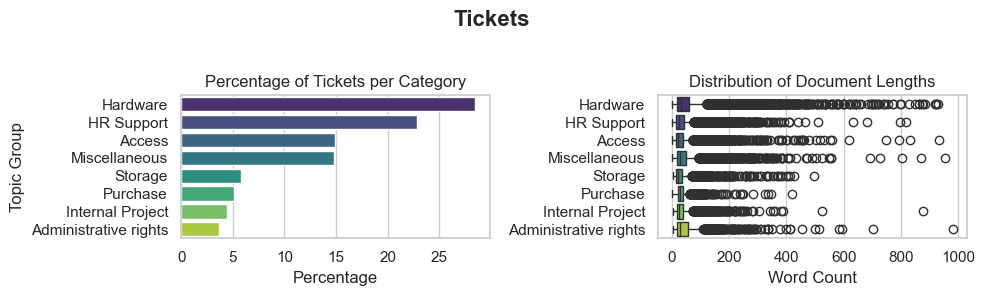

In [5]:
# Calculate percentages per category
category_counts = df["Topic_group"].value_counts(normalize=True) * 100
category_percentages = category_counts.reset_index()
category_percentages.columns = ["Topic_group", "Percentage"]

# Calculate lengths of documents as word count
df["Document_Length"] = df["Document"].apply(lambda x: len(x.split()))

# Get the order of categories from the barplot data
category_order = category_percentages["Topic_group"]

# Create a consistent color palette
palette = sns.color_palette("viridis", len(category_order))
color_mapping = dict(zip(category_order, palette))

# Create the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10,3))

# Barplot: Percentage per category
sns.barplot(
    data=category_percentages,
    x="Percentage",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[0]
)
axes[0].set_title("Percentage of Tickets per Category")
axes[0].set_xlabel("Percentage")
axes[0].set_ylabel("Topic Group")

# Boxplot: Distribution of document lengths
sns.boxplot(
    data=df,
    x="Document_Length",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[1]
)
axes[1].set_title("Distribution of Document Lengths")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("")

# Set the suptitle
fig.suptitle("Tickets", fontsize=16, weight="bold")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Prepare the data

Split the data and build mappings from text labels to integer labels and vice versa.

In [6]:
test_size=0.2
random_state=42

"""Split data into train and test sets, and map labels to integers."""
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integers
unique_labels = list(set(train_labels + test_labels))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integers as lists
train_labels = [label_to_id[label] for label in train_labels]
test_labels = [label_to_id[label] for label in test_labels]

### Compute TFIDF Feature Vectors

### What Are TF-IDF Vectors?

TF-IDF (Term Frequency-Inverse Document Frequency) vectors are a statistical representation of text data that capture the importance of terms within a document relative to a collection of documents (the corpus). This method assigns a weight to each term based on its frequency in a specific document (term frequency, TF) and how common or rare it is across all documents in the corpus (inverse document frequency, IDF). The result is a sparse, numerical vector for each document, where each dimension corresponds to a unique term in the vocabulary. TF-IDF is widely used in text mining, natural language processing, and machine learning as a feature extraction technique for tasks like classification, clustering, and information retrieval. However, as the size of the vocabulary grows, the dimensionality of the TF-IDF vectors increases, potentially leading to computational inefficiencies and the curse of dimensionality.

---

### Tricks for Limiting Dimensionality

To address the high dimensionality of TF-IDF vectors, several preprocessing techniques can be applied to reduce the vocabulary size while retaining the most meaningful terms. **Stemming** is one such method, where words are reduced to their root forms (e.g., "running" → "run"), grouping related words into a single term and thereby reducing the vocabulary size. Similarly, **lemmatization** refines this process by considering the context and part of speech to produce base forms. Removing **stopwords** like "the," "is," and "and" eliminates common, less informative terms that appear frequently across documents. Setting thresholds for **minimum and maximum document frequency** (e.g., `min_df` and `max_df`) ensures that terms appearing in very few documents or nearly all documents are excluded from the vocabulary. Additionally, limiting the vocabulary size directly with `max_features` retains only the top terms with the highest importance scores. Finally, incorporating **n-grams** (e.g., bigrams and trigrams) helps capture multi-word phrases, adding context while keeping the range limited to prevent explosive growth in dimensionality. Combining these techniques creates a more compact, computationally efficient representation of text data while preserving its semantic richness.

In [7]:

tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common English stopwords
    min_df=2,  # Remove rare terms (appear in fewer than 2 documents)
    max_df=0.85,  # Remove overly common terms (appear in more than 85% of documents)
    max_features=10000,  # Limit vocabulary size to top 1000 terms
    ngram_range=(1, 3)  # Include unigrams, bigrams, and trigrams
)

# Fit the vectorizer and transform the input texts
train_features = tfidf_vectorizer.fit_transform(train_texts)
test_features = tfidf_vectorizer.transform(test_texts)

In [8]:
train_features

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1475678 stored elements and shape (38269, 10000)>

In [ ]:
def plot_confusion_matrix(y_true, y_pred, id_to_label, title="Confusion Matrix", normalize=False, figsize=(8, 8)):
    """
    Plot a confusion matrix with customizable figure size.
    
    Parameters:
    - y_true: array-like of shape (n_samples,) - Ground truth (correct) target values.
    - y_pred: array-like of shape (n_samples,) - Estimated targets as returned by a classifier.
    - id_to_label: dict - Mapping from class ID to class label.
    - title: str (default="Confusion Matrix") - Title of the confusion matrix plot.
    - normalize: bool (default=False) - Whether to normalize the confusion matrix.
    - figsize: tuple (default=(8, 8)) - Size of the figure (width, height).
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true') if normalize else confusion_matrix(y_true, y_pred)
    labels = [id_to_label[i] for i in range(len(id_to_label))]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(cmap="Blues", xticks_rotation="vertical", ax=ax)
    ax.set_title(title)
    plt.show()


Classification Report:
                       precision    recall  f1-score   support

               Access       0.93      0.86      0.89      1455
Administrative rights       0.87      0.69      0.77       342
           HR Support       0.85      0.84      0.84      2107
             Hardware       0.79      0.89      0.83      2760
     Internal Project       0.91      0.78      0.84       451
        Miscellaneous       0.81      0.82      0.81      1400
             Purchase       0.97      0.87      0.92       497
              Storage       0.94      0.84      0.89       556

             accuracy                           0.85      9568
            macro avg       0.88      0.82      0.85      9568
         weighted avg       0.85      0.85      0.85      9568



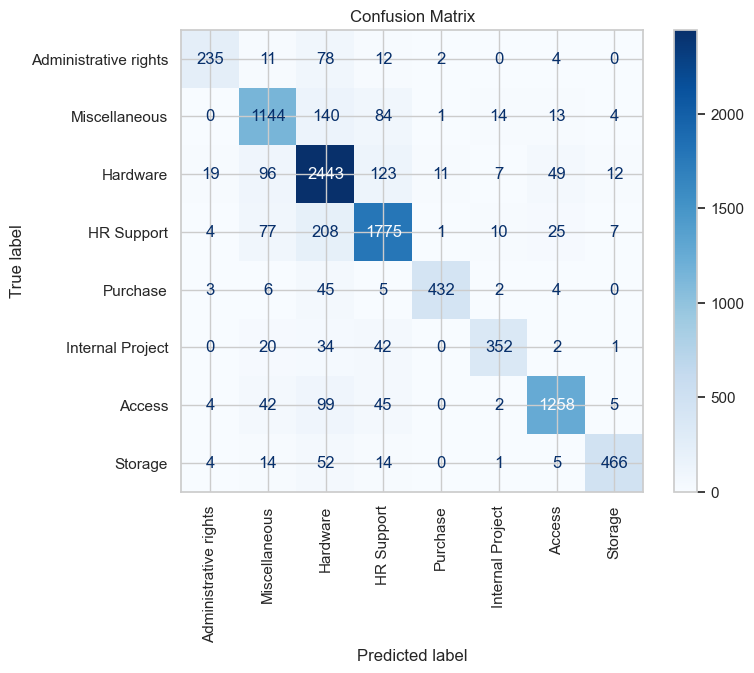

In [12]:
# Initialize and fit the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(train_features, train_labels)

# Make predictions on the test set
test_predictions = model.predict(test_features)

# Convert integer labels to string labels for the test set and predictions
test_labels_str = [id_to_label[label] for label in test_labels]
predictions_str = [id_to_label[label] for label in test_predictions]

# Compute classification metrics
print("Classification Report:")
print(classification_report(test_labels_str, predictions_str))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels_str, predictions_str, labels=list(id_to_label.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
disp.ax_.set_title("Confusion Matrix")

# Create and return a DataFrame with test labels and predictions
results_df = pd.DataFrame({
    "Test Labels": test_labels_str,
    "Predictions": predictions_str
})

### Finetune Distilbert

In [2]:
data_path = Path('./data/IT_tickets_classify.csv').resolve() 
df = pd.read_csv(data_path)

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

In [3]:
test_size=0.2
random_state=42

"""Split data into train and test sets, and map labels to integers."""
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integers
unique_labels = list(set(train_labels + test_labels))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

train_labels = [label_to_id[label] for label in train_labels]
test_labels = [label_to_id[label] for label in test_labels]

In [ ]:
# Load Pre-trained Model and Tokenizer
model_checkpoint = "distilbert-base-uncased" # about 88%, bs = 32 OK

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Set a padding token (use an existing one or define a new one)
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))  # Adjust model embedding size



In [37]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def tokenize_dataset(tokenizer, texts, labels):
    """Tokenize the dataset."""
    dataset = Dataset.from_dict({"text": texts, "label": labels})
    tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True)
    return tokenized_dataset

# Tokenize datasets
tokenized_train = tokenize_dataset(tokenizer, train_texts, train_labels)
tokenized_test = tokenize_dataset(tokenizer, test_texts, test_labels)

batch_size = 32 # reduce if memory issues

models_and_logs_dir = MODELS_PATH / 'L08_fine_tune_distilbert'

Using device: cuda


Map:   0%|          | 0/38269 [00:00<?, ? examples/s]

Map:   0%|          | 0/9568 [00:00<?, ? examples/s]

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_to_id)).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=models_and_logs_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    logging_dir=models_and_logs_dir / "logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    logging_steps=10
    )

def compute_metrics(pred):
    """Compute evaluation metrics."""
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
output = trainer.train(resume_from_checkpoint=checkpoint)

  0%|          | 0/2392 [00:00<?, ?it/s]

{'loss': 1.9125, 'grad_norm': 3.2252469062805176, 'learning_rate': 9.95819397993311e-05, 'epoch': 0.01}
{'loss': 1.778, 'grad_norm': 2.8311331272125244, 'learning_rate': 9.916387959866222e-05, 'epoch': 0.02}
{'loss': 1.6357, 'grad_norm': 3.5252091884613037, 'learning_rate': 9.874581939799331e-05, 'epoch': 0.03}
{'loss': 1.3657, 'grad_norm': 4.434165954589844, 'learning_rate': 9.832775919732441e-05, 'epoch': 0.03}
{'loss': 1.3091, 'grad_norm': 5.27621603012085, 'learning_rate': 9.790969899665552e-05, 'epoch': 0.04}
{'loss': 0.9781, 'grad_norm': 4.364531517028809, 'learning_rate': 9.749163879598663e-05, 'epoch': 0.05}
{'loss': 0.9412, 'grad_norm': 6.837282180786133, 'learning_rate': 9.707357859531773e-05, 'epoch': 0.06}
{'loss': 0.8685, 'grad_norm': 3.5339455604553223, 'learning_rate': 9.665551839464884e-05, 'epoch': 0.07}
{'loss': 0.9584, 'grad_norm': 5.304385185241699, 'learning_rate': 9.623745819397993e-05, 'epoch': 0.08}
{'loss': 0.7658, 'grad_norm': 3.64548659324646, 'learning_rate'

  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.39879274368286133, 'eval_accuracy': 0.8637123745819398, 'eval_f1': 0.863832333120823, 'eval_precision': 0.868187890344934, 'eval_recall': 0.8637123745819398, 'eval_runtime': 20.2756, 'eval_samples_per_second': 471.898, 'eval_steps_per_second': 14.747, 'epoch': 1.0}
{'loss': 0.3483, 'grad_norm': 4.158239841461182, 'learning_rate': 4.987458193979933e-05, 'epoch': 1.0}
{'loss': 0.2764, 'grad_norm': 3.9074342250823975, 'learning_rate': 4.945652173913044e-05, 'epoch': 1.01}
{'loss': 0.3051, 'grad_norm': 3.3169867992401123, 'learning_rate': 4.9038461538461536e-05, 'epoch': 1.02}
{'loss': 0.2991, 'grad_norm': 4.322210311889648, 'learning_rate': 4.862040133779264e-05, 'epoch': 1.03}
{'loss': 0.2867, 'grad_norm': 4.678431987762451, 'learning_rate': 4.820234113712375e-05, 'epoch': 1.04}
{'loss': 0.3132, 'grad_norm': 2.7319414615631104, 'learning_rate': 4.7784280936454854e-05, 'epoch': 1.05}
{'loss': 0.2187, 'grad_norm': 5.047741413116455, 'learning_rate': 4.736622073578595e-05, '

  0%|          | 0/299 [00:00<?, ?it/s]

{'eval_loss': 0.3511567711830139, 'eval_accuracy': 0.8827341137123745, 'eval_f1': 0.8826346980548654, 'eval_precision': 0.8827954060671425, 'eval_recall': 0.8827341137123745, 'eval_runtime': 20.6606, 'eval_samples_per_second': 463.104, 'eval_steps_per_second': 14.472, 'epoch': 2.0}
{'train_runtime': 539.3233, 'train_samples_per_second': 141.915, 'train_steps_per_second': 4.435, 'train_loss': 0.39316378212393727, 'epoch': 2.0}


In [43]:
predictions = trainer.predict(tokenized_test)


  0%|          | 0/299 [00:00<?, ?it/s]

In [44]:
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(id_to_label.values())))

def plot_confusion_matrix(y_true, y_pred, id_to_label, title="Confusion Matrix", normalize=False):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true') if normalize else confusion_matrix(y_true, y_pred)
    labels = [id_to_label[i] for i in range(len(id_to_label))]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    disp.ax_.set_title(title)

Classification Report:
                       precision    recall  f1-score   support

             Purchase       0.94      0.90      0.92       497
Administrative rights       0.84      0.77      0.81       342
              Storage       0.90      0.91      0.91       556
               Access       0.91      0.93      0.92      1455
     Internal Project       0.90      0.85      0.87       451
           HR Support       0.89      0.88      0.88      2107
             Hardware       0.87      0.88      0.87      2760
        Miscellaneous       0.85      0.86      0.86      1400

             accuracy                           0.88      9568
            macro avg       0.89      0.87      0.88      9568
         weighted avg       0.88      0.88      0.88      9568



In [ ]:
def plot_confusion_matrix(y_true, y_pred, id_to_label, title="Confusion Matrix", normalize=False):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true') if normalize else confusion_matrix(y_true, y_pred)
    labels = [id_to_label[i] for i in range(len(id_to_label))]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    disp.ax_.set_title(title)

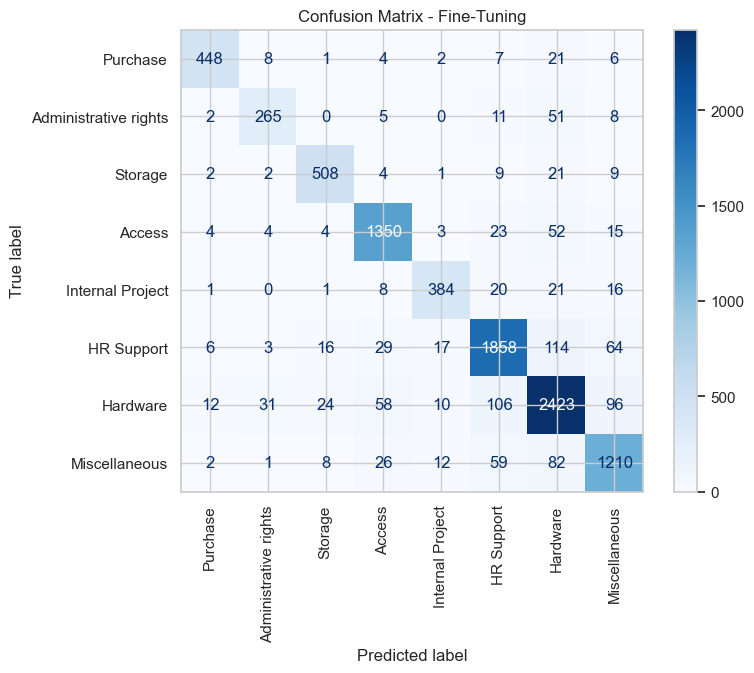

In [45]:

plot_confusion_matrix2(y_true, y_pred, id_to_label, title="Confusion Matrix - Fine-Tuning")